<h1 style="line-height: 1.3">W4111: Introduction to Databases $-$ NoSQL and Examples</h1>

## Neo4J

- Graphs have Nodes and Relationships.


- The py2neo [_object-graph mapping_](https://py2neo.org/v3/ogm.html#py2neo.ogm.py2neo.ogm.GraphObject) packages simplifies mapping between Neo4j and Python objects. There is a good starter tutorial at [Medium](https://medium.com/neo4j/py2neo-v4-2bedc8afef2).


- The sample Movie DB has Person and Movie, and some relationships.


- You can represent this in Python with


In [11]:
from py2neo import Graph
from py2neo.ogm import GraphObject, Property, RelatedFrom, RelatedTo


graph = Graph("bolt://localhost:7687", auth=("neo4j", "neo4jnew"))


class Movie(GraphObject):
    __primarykey__ = "title"
    title = Property()
    tagline = Property()
    released = Property()
    actors = RelatedFrom("Person", "ACTED_IN")
    directors = RelatedFrom("Person", "DIRECTED")
    producers = RelatedFrom("Person", "PRODUCED")

class Person(GraphObject):
    __primarykey__ = "name"
    name = Property()
    born = Property()
    acted_in = RelatedTo(Movie)
    directed = RelatedTo(Movie)
    produced = RelatedTo(Movie)


- And some simple tests

In [12]:
def t1():
    x = graph.nodes.match("Person", name="Keanu Reeves").first()
    print(type(x))
    print('Born = ', x['born'])
    y = Person.wrap(x)
    print(y.born)
    print(y)

def t2():
    st = Person.match(graph).where("_.born = 1960")
    print("People born in 1960 and the movies they acted in:")
    for s in st:
        print(s.name, s.born)

        for m in s.acted_in:
            print("\t", m.title, m.released)

In [5]:
t1()

<class 'py2neo.data.Node'>
Born =  1964
1964
<Person name='Keanu Reeves'>


In [4]:
t2()

People born in 1960 and the movies they acted in:
Annabella Sciorra 1960
	 What Dreams May Come 1998
John Goodman 1960
	 Speed Racer 2008
Oliver Platt 1960
	 Bicentennial Man 1999
	 Frost/Nixon 2008
Hugo Weaving 1960
	 V for Vendetta 2006
	 The Matrix Reloaded 2003
	 The Matrix Revolutions 2003
	 The Matrix 1999
	 Cloud Atlas 2012


## Homework 4

### Setup

- Install Neo4j Community Edition. Do not install the desktop. Just install the server.


- Add py2neo to your environments, if necessary.


- Using PyCharm to develop and test your code is the best practice. You can copy the code into the notebook when done developing and testing.


### Concept

- Load information from lahman2017.people, lahman2017.teams, lahman2017.appearances. The code for loading the database is below.


- Add a Node type for _Fan._ __NOTE:__ You do not need to add a class unlike the pattern above.


- Allow a Fan to follow other Fans, Comment on a Team and/or Player and response to Comments.


### Data Model

- The loading function do not all of the data. The loaded is scoped by year range, which you will see in code below. (Loading the full database would create performance problems for you and require getting a licensed version).


- Node Labels:
    - Team: Core information loaded from Lahman 2017
    - Player: Core information loaded from Lahman 2017
    - Fan: New entity representing a baseball fan.
    - Comment: A Fan made a comment on a team or player.
    
    
- Relationships:
    - Appeared: Represents the fact that a player "appeared" for a team in a year. Loaded from a small subset of Lahman 2017.
    - Supports: A Fan supports a Team
    - Follows: A Fan follows (the comments of) another Fan.
    - CommentOn: Represents the relationship between a Comment and a Team/Player.
    - CommentBy: Relationship between a Fan and Comment.
    - ResponseTo: Indicates that a Comment is a ResponseTo a Comment.

### HW4 Part 1: Implementation and Template


- There are two parts to HW4:
    1. Simple social model and topics in Neo4j
    2. API result cache for database query results using Redis. A section later in the notebook explains part 2.
    

- HW4:
    - Starts with a Python implementation template for a class _FanGraph._
        - Contains many example methods.
        - Placeholder for the methods that you need to implement.
    - Some sample client code for creating and finding nodes and relationships.
    - A few test cases to get you started and verify correctness. You need to implement a more complete set of tests.
    
    
- HW4 tasks:
    - Load the Neo4j database using the load functions below.
    - Implement and test the incomplete methods (ones with "pass") in the template.
    
### Template
    

In [13]:
from py2neo import data, Graph, NodeMatcher, Node, Relationship, RelationshipMatcher

"""
See https://py2neo.org/v4/
"""

"""
NOTE:
    1. I did some basic testing, debugging, etc. but there may be errors.
    2. You can complain about the errors if you want but my response will be, "No Template for You!"
"""

import json
import uuid


class FanGraph(object):
    """
    This object provides a set of helper methods for creating and retrieving nodes and relationships from
    a Neo4j database holding information about players, teams, fans, comments and their relationships.
    """

    # Note:
    # I tend to avoid object mapping frameworks. Object mapping frameworks are fun in the beginning
    # but tend to be annoying after a while. So, I did not create types Player, Team, etc.
    #

    # Connects to the DB and sets a Graph instance variable.
    # Also creates a NodeMatcher and RelationshipMatcher, which are a py2neo framework classes.
    def __init__(self, auth=('neo4j', 'neo4jnew'), host='localhost', port=7687, secure=False, ):
        self._graph = Graph(secure=secure,
                            bolt=True,
                            auth=auth,
                            host=host,
                            port=port)
        self._node_matcher = NodeMatcher(self._graph)
        self._relationship_matcher = RelationshipMatcher(self._graph)

    def run_q(self, qs, args):
        """

        :param qs: Query string that may have {} slots for parameters.
        :param args: Dictionary of parameters to insert into query string.
        :return:  Result of the query, which executes as a single, standalone transaction.
        """
        try:
            tx = self._graph.begin(autocommit=False)
            result = self._graph.run(qs, args)
            return result
        except Exception as e:
            print("Run exaception = ", e)

    def run_match(self, labels=None, properties=None):
        """
        Uses a NodeMatcher to find a node matching a "template."
        :param labels: A list of labels that the node must have.
        :param properties: A dictionary of {property_name: property_value} defining the template that the
            node must match.
        :return: An array of Node objects matching the pattern.
        """
        # ut.debug_message("Labels = ", labels)
        # ut.debug_message("Properties = ", json.dumps(properties))

        if labels is not None and properties is not None:
            result = self._node_matcher.match(labels, **properties)
        elif labels is not None and properties is None:
            result = self._node_matcher.match(labels)
        elif labels is None and properties is not None:
            result = self._node_matcher.match(**properties)
        else:
            raise ValueError("Invalid request. Labels and properties cannot both be None.")

        # Convert NodeMatch data into a simple list of Nodes.
        full_result = []
        for r in result:
            full_result.append(r)

        return full_result

    def find_nodes_by_template(self, tmp):
        """

        :param tmp: A template defining the label and properties for Nodes to return. An
         example is { "label": "Fan", "template" { "last_name": "Ferguson", "first_name": "Donald" }}
        :return: A list of Nodes matching the template.
        """
        labels = tmp.get('label', None)
        props = tmp.get("template", None)
        result = self.run_match(labels=labels, properties=props)
        return result

    # Create and save a new node for  a 'Fan.'
    def create_fan(self, uni, last_name, first_name):
        """

        :param uni: uni
        :param last_name: Obvious
        :param first_name: Obvious
        :return: Node created.

        NOTE: This does not check uni uniqueness. We could do using transactions or setting a constraint
        on the database.
        """
        n = Node("Fan", uni=uni, last_name=last_name, first_name=first_name)
        tx = self._graph.begin(autocommit=True)
        tx.create(n)
        return n

    # Given a UNI, return the node for the Fan.
    def get_fan(self, uni):
        n = self.find_nodes_by_template({"label": "Fan", "template": {"uni": uni}})
        if n is not None and len(n) > 0:
            # I should throw an exception here if there is more than 1.
            n = n[0]
        else:
            n = None

        return n

    def create_player(self, player_id, last_name, first_name):
        n = Node("Player", player_id=player_id, last_name=last_name, first_name=first_name)
        tx = self._graph.begin(autocommit=True)
        tx.create(n)
        return n

    def get_player(self, player_id):
        n = self.find_nodes_by_template({"label": "Player", "template": {"player_id": player_id}})
        if n is not None and len(n) > 0:
            n = n[0]
        else:
            n = None

        return n

    def create_team(self, team_id, team_name):
        n = Node("Team", team_id=team_id, team_name=team_name)
        tx = self._graph.begin(autocommit=True)
        tx.create(n)
        return n

    def get_team(self, team_id):
        n = self.find_nodes_by_template({"label": "Team", "template": {"team_id": team_id}})
        if n is not None and len(n) > 0:
            n = n[0]
        else:
            n = None

        return n

    def create_supports(self, uni, team_id):
        """
        Create a SUPPORTS relationship from a Fan to a Team.
        :param uni: The UNI for a fan.
        :param team_id: An ID for a team.
        :return: The created SUPPORTS relationship from the Fan to the Team
        """
        f = self.get_fan(uni)
        t = self.get_team(team_id)
        r = Relationship(f, "SUPPORTS", t)
        tx = self._graph.begin(autocommit=True)
        tx.create(r)
        return r

    def get_appearance(self, player_id, team_id, year_id):
        """
        Get the information about appearances for a player and team.
        :param player_id: player_id
        :param team_id: team_id
        :param year_id: The year for getting appearances.
        :return:
        """
        try:
            # Get the Nodes at the ends of the relationship representing appearances.
            p = self.get_player(player_id)
            t = self.get_team(team_id)

            # Run a match looking for relationships of a specific type linking the nodes.
            rm = self._graph.match(nodes=[p, t], r_type="APPEARED")
            result = []

            # If there is a list of relationships.
            if rm is not None:
                for r in rm:

                    # The type will be a class APPEARED() because of the OO mapping.
                    node_type = type(r).__name__
                    year = r['year']

                    # If the type and year are correct, add to result
                    if node_type == "APPEARED" and (year == year_id or year_id is None):
                        result.append(r)

                return result
            else:
                return None
        except Exception as e:
            print("get_appearance: Exception e = ", e)
            raise e

    # Create an APPEARED relationship from a player to a Team
    def create_appearance_all(self, player_id, team_id, year, games):
        """

        :param player_id: O
        :param team_id:
        :param year:
        :param games:
        :return:
        """
        try:
            tx = self._graph.begin(autocommit=False)
            q = "match (n:Player {player_id: '" + player_id + "'}), " + \
                "(t:Team {team_id: '" + team_id + "'}) " + \
                "create (n)-[r:APPEARED { games: " + str(games) + ", year : " + str(year) + \
                "}]->(t)"
            result = self._graph.run(q)
            tx.commit()
        except Exception as e:
            print("create_appearances: exception = ", e)

    # Create a FOLLOWS relationship from a Fan to another Fan.
    def create_follows(self, follower, followed):
        f = self.get_fan(follower)
        t = self.get_fan(followed)
        r = Relationship(f, "FOLLOWS", t)
        tx = self._graph.begin(autocommit=True)
        tx.create(r)

    def get_comment(self, comment_id):
        """

        :param comment_id: Comment ID
        :return: Comment
        """
        n = self.find_nodes_by_template({"label": "Comment", "template": {"comment_id": comment_id}})
        if n is not None and len(n) > 0:
            n = n[0]
        else:
            n = None

        return n

    def create_comment(self, uni, comment, team_id=None, player_id=None, ):
        """
        Creates a comment
        :param uni: The UNI for the Fan making the comment.
        :param comment: A simple string.
        :param team_id: A valid team ID or None. team_id and player_id cannot BOTH be None.
        :param player_id: A valid player ID or None
        :return: The Node representing the comment.
        """

        if uni is None or comment is None or (player_id is None and team_id is None):
            raise ValueError("create_comment: invalid input.")
        comment_id = str(uuid.uuid4())
        fan = None
        team = None
        player = None
        tx = None

        try:
            tx = self._graph.begin()

            fan = self.get_fan(uni)
            if fan is None:
                raise ValueError("create_comment: Fan node not found.")

            if team_id is not None:
                team = self.get_team(team_id)
                if team is None:
                    raise ValueError("create_comment: Team node not found.")

            if player_id is not None:
                player = self.get_player(player_id)
                if player is None:
                    raise ValueError("create_comment: Player node not found.")

            c = Node("Comment", comment_id=comment_id, comment=comment)
            tx.create(c)

            pc = Relationship(fan, "COMMENT_BY", c)
            tx.create(pc)

            if player is not None:
                pr = Relationship(c, "COMMENT_ON", player)
                pf = Relationship(fan, "FAN_COMMENT_ON", player)
                tx.create(pr)
                tx.create(pf)

            if team is not None:
                p2 = Relationship(c, "COMMENT_ON", team)
                tx.create(p2)

            tx.commit()

            return c

        except Exception as e:
            if tx:
                tx.rollback()

    def create_sub_comment(self, uni, origin_comment_id, comment):
        """
        Create a sub-comment (response to a comment or response) and links with parent in thread.
        :param uni: ID of the Fan making the comment.
        :param origin_comment_id: Id of the comment to which this is a response.
        :param comment: Comment string
        :return: Created comment.
        """

        if uni is None or comment is None or origin_comment_id is None:
            raise ValueError("create_comment: invalid input.")
        sub_comment_id = str(uuid.uuid4())
        origin_comment = self.get_comment(origin_comment_id)
        try:
            tx = self._graph.begin()

            c = Node("Response", origin_comment_id=origin_comment_id, comment=comment)
            tx.create(c)

            if origin_comment is not None:
                sc = Relationship(c, "RESPONSE_OF", origin_comment)
                tx.create(sc)

            tx.commit()

            return c

        except Exception as e:
            if tx:
                tx.rollback()

    def get_sub_comments(self, comment_id):
        """

        :param comment_id: The unique ID of the comment.
        :return: The sub-comments.
        """

        q = "match (sc:Comment)<-[r:RESPONSE_OF]-(c:Response) where sc.comment_id={cid} return sc,r,c"
        res = fg.run_q(q, {"cid": comment_id})

        return res

    def get_player_comments(self, player_id):
        """
        Gets all of the comments associated with a player, Also returns the Nodes for people making the comments.
        :param player_id: ID of the player.
        :return: Graph containing comment, comment streams and commenters.
        """

        q = "match (comment:Comment)-[rc:COMMENT_ON]-(player:Player {player_id: {pid}})-[rf:FAN_COMMENT_ON]-(fan:Fan)" + \
            "return fan.uni, fan.last_name, fan.first_name, comment.comment_id, comment.comment, player.player_id, player.last_name, player.first_name"
        res = fg.run_q(q, {"pid": player_id})

        return res

    def get_team_comments(self, team_id):
        """
        Gets all of the comments associated with a team.  Also returns the Nodes for people making the comments.
        :param player_id: ID of the team.
        :return: Graph containing comment, comment streams and commenters.
        """

        q = "match (c:Comment)-[r:COMMENT_ON]->(t:Team) where t.team_id={tid} return t,r,c"
        res = fg.run_q(q, {"tid": team_id})

        return res

    def get_players_by_team(self, team_id, yearid):
        """

        :param team_id: The ID of a team.
        :param yearid: A year.
        :return: Returns the players who played for the team in the year.
        """

        q = "match (t:Team {team_id: {tid}})<-[a:APPEARED {year: {yid}}]-(p:Player) " + \
            "return t.team_id, t.team_name, a.year, a.games, p.player_id, p.last_name, " + \
            "p.first_name"
        c = self._graph.run(q, tid=team_id, yid=yearid)
        return c

### Tests and Examples

#### Setup The Environment

- These tests come from my solution to the homework. I have to direct the notebook's Python kernel to my implementation, which completes the template above.

In [14]:
import json
import pandas as pd

pd.set_option('display.width', 132)

In [15]:
fg = FanGraph(auth = ('neo4j', 'neo4jnew'),
                  host="localhost",
                  port=7687,
                  secure=False)

In [16]:
print("fg = ", fg)

fg =  <__main__.FanGraph object at 0x119451240>


#### Simple Tests and Examples

##### Query Example

In [17]:
def t1(name):
    """
    Find all the movies that a person with name 'name' is related to.
    Return information as a Pandas data frame.
    """
    
    # The match is (Person)-[any relationship]->(Movie)
    # Person name must be the passed {name}.
    # Return a list of dictionaries of the attributes/values.
    #
    qs = "match (t:Person)-[r]->(t2:Movie) " + \
    " where t.name={name} " + \
    " return t.name, t2.title, t2.released, r.roles"
    
    # Set the name parameter for the query
    ag = {"name": name}
    
    # Use the handy, dandy run_q method on FanGraph
    r = fg.run_q(qs, ag)
    
    # Convert the result into a DataFrame
    x = pd.DataFrame(r.data())
    
    # Make sure the columns are in the "right" order. 
    # Python dicts are unordered, which means the data frame's columns
    # might be in a weird order.
    x = x[['t.name', 't2.title', 't2.released', 'r.roles']]
    return x

In [41]:
# Find Tom Hanks
x = t1('Tom Hanks')
print(x)

       t.name                t2.title  t2.released                                            r.roles
0   Tom Hanks       The Polar Express         2004  [Hero Boy, Father, Conductor, Hobo, Scrooge, S...
1   Tom Hanks    Charlie Wilson's War         2007                              [Rep. Charlie Wilson]
2   Tom Hanks    Sleepless in Seattle         1993                                      [Sam Baldwin]
3   Tom Hanks          The Green Mile         1999                                    [Paul Edgecomb]
4   Tom Hanks  Joe Versus the Volcano         1990                                        [Joe Banks]
5   Tom Hanks       That Thing You Do         1996                                               None
6   Tom Hanks       That Thing You Do         1996                                        [Mr. White]
7   Tom Hanks       The Da Vinci Code         2006                               [Dr. Robert Langdon]
8   Tom Hanks   A League of Their Own         1992                                

##### Create a Fan

In [11]:
def test_create_fan():
    r = fg.create_fan(uni="dff99999", last_name="Vader", first_name="Donald")
    return r

In [12]:
f = test_create_fan()
print("Create returned ...", f)
print("The type is ... ", type(f))

Create returned ... (_6412:Fan {first_name: 'Donald', last_name: 'Vader', uni: 'dff99999'})
The type is ...  <class 'py2neo.data.Node'>


- Notice that this returns a py2neo Python class Node that holds the data.


- Let's probe this a little.


In [194]:
# Get the labels.
f.labels

:Fan

In [114]:
f.keys()

dict_keys(['uni', 'last_name', 'first_name'])

In [115]:
f.items()

dict_items([('uni', 'dff99999'), ('last_name', 'Vader'), ('first_name', 'Donald')])

In [116]:
for k,v in f.items():
    print(k, ": ", v)

uni :  dff99999
last_name :  Vader
first_name :  Donald


- The Node is 'sort of' a dictionary.


- What are all the attributes? What did we actually get? Look in the documentation.


- Or use the Python function.

In [195]:
# Load the introspection/reflection functions.
import inspect

# Get the class object for the Fan (https://docs.python.org/3/tutorial/classes.html#class-objects)
cf = f.__class__

# Get the "method resolution order," i.e. the inheritance hierarchy.
inspect.getmro(cf)

(py2neo.data.Node,
 py2neo.data.Entity,
 py2neo.data.PropertyDict,
 dict,
 py2neo.data.Walkable,
 py2neo.data.Subgraph,
 object)

In [196]:
# Get all of the attributes and methods. The __xxx__ are internal. The others are attributes and functions you can
# and which are documented.
dir(f)

['_Node__ensure_labels',
 '_Subgraph__nodes',
 '_Subgraph__relationships',
 '_Walkable__sequence',
 '__add__',
 '__and__',
 '__bool__',
 '__class__',
 '__contains__',
 '__db_create__',
 '__db_delete__',
 '__db_exists__',
 '__db_merge__',
 '__db_pull__',
 '__db_push__',
 '__db_separate__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__uuid__',
 '__walk__',
 '__weakref__',
 '__xor__',
 '_labels',
 '_remote_labels',
 '_stale',
 'add_label',
 'cast',
 'clear',
 'clear_labels',
 'copy',
 'end_node',
 'fromkeys',
 'get',
 'graph',
 'has_label',
 'identity',
 'items',
 'keys',


In [197]:
q = "match (p {name: 'Tom Hanks'})-[r:ACTED_IN]->(m) return p,r,m"
r = fg.run_q(q, None)
print(r)

In [198]:
# Cursor is similar to cursor in other databases.
for t in r:
    print(t)
    

<Record p=(_18574:Person {born: 1956, name: 'Tom Hanks'}) r=(Tom Hanks)-[:ACTED_IN {roles: ['Hero Boy', 'Father', 'Conductor', 'Hobo', 'Scrooge', 'Santa Claus']}]->(_18664) m=(_18664:Movie {released: 2004, tagline: 'This Holiday Season\u2026 Believe', title: 'The Polar Express'})>
<Record p=(_18574:Person {born: 1956, name: 'Tom Hanks'}) r=(Tom Hanks)-[:ACTED_IN {roles: ['Rep. Charlie Wilson']}]->(_18662) m=(_18662:Movie {released: 2007, tagline: "A stiff drink. A little mascara. A lot of nerve. Who said they couldn't bring down the Soviet empire.", title: "Charlie Wilson's War"})>
<Record p=(_18574:Person {born: 1956, name: 'Tom Hanks'}) r=(Tom Hanks)-[:ACTED_IN {roles: ['Sam Baldwin']}]->(_18576) m=(_18576:Movie {released: 1993, tagline: 'What if someone you never met, someone you never saw, someone you never knew was the only someone for you?', title: 'Sleepless in Seattle'})>
<Record p=(_18574:Person {born: 1956, name: 'Tom Hanks'}) r=(Tom Hanks)-[:ACTED_IN {roles: ['Paul Edgecomb'

##### Generic Node find_by_template()

- It should not surprise you that our graph object has this function.
    - We had it for CSVDataTable.
    - We had it for RDBDataTable.
    - We have it here.
    
    
- We will "sort of" have for Redis

In [13]:
def t_find_by_template():
    
    # Test the find_by_template() function.
    # Template includes the Label, which is a slightly different for than the find_by_template() format.
    # we previously used.
    # The Label replaces the "table name." There are no tables in Neo4j
    tmp = {"label": "Person", "template": {"name": "Tom Hanks"}}
    r = fg.find_nodes_by_template(tmp)
    return r

In [14]:
n = t_find_by_template()
print(n)
print(type(n))

[(_18574:Person {born: 1956, name: 'Tom Hanks'})]
<class 'list'>


In [15]:
from py2neo import NodeMatcher

# Should not do this, but what the heck.
nm = fg._node_matcher
n2 = nm.match(name="Tom Hanks")
n2

In [16]:
y = n2.first()
print(y)
print(type(y))

(_18574:Person {born: 1956, name: 'Tom Hanks'})
<class 'py2neo.data.Node'>


In [17]:
from py2neo import NodeMatcher

# Should not do this, but what the heck.
rm = fg._relationship_matcher
r2 = rm.match([y])
r2

In [18]:
for rr in r2:
    print(rr)

(Tom Hanks)-[:ACTED_IN {roles: ['Hero Boy', 'Father', 'Conductor', 'Hobo', 'Scrooge', 'Santa Claus']}]->(_18664)
(Tom Hanks)-[:ACTED_IN {roles: ['Rep. Charlie Wilson']}]->(_18662)
(Tom Hanks)-[:ACTED_IN {roles: ['Sam Baldwin']}]->(_18576)
(Tom Hanks)-[:ACTED_IN {roles: ['Paul Edgecomb']}]->(_18633)
(Tom Hanks)-[:ACTED_IN {roles: ['Joe Banks']}]->(_18581)
(Tom Hanks)-[:DIRECTED {}]->(_18588)
(Tom Hanks)-[:ACTED_IN {roles: ['Mr. White']}]->(_18588)
(Tom Hanks)-[:ACTED_IN {roles: ['Dr. Robert Langdon']}]->(_18614)
(Tom Hanks)-[:ACTED_IN {roles: ['Jimmy Dugan']}]->(_18665)
(Tom Hanks)-[:ACTED_IN {roles: ['Joe Fox']}]->(_18570)
(Tom Hanks)-[:ACTED_IN {roles: ['Jim Lovell']}]->(_18647)
(Tom Hanks)-[:ACTED_IN {roles: ['Chuck Noland']}]->(_18653)
(Tom Hanks)-[:ACTED_IN {roles: ['Zachry', 'Dr. Henry Goose', 'Isaac Sachs', 'Dermot Hoggins']}]->(_18608)


#### Load Data

- __NOTE:__ I previously ran this code. It is just here for teaching purposes and to allow you to use it.


- There are tests below using FanGraph functions to explore the loaded data.

In [18]:
import pymysql

cnx = pymysql.connect(host='localhost',
                             user='dbuser',
                             password='dbuserdbuser',
                             db='lahman2017',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

In [26]:
def load_players():
    """
    Load a subset of the player data. We only load a subset of the columns and the rows.
    """

    q = "SELECT playerID, nameLast, nameFirst FROM People where  " + \
        "exists (select * from appearances where appearances.playerID = " + \
        " people.playerID and yearID >= 2010)"

    curs = cnx.cursor()
    curs.execute(q)

    # This is an example of using a cursor. We could have used fetchall() but
    # I wanted to give you an example of iterating using a cursor.
    r = curs.fetchone()
    cnt = 0
    
    # Loop until we are out of rows.
    while r is not None:
        print(r)
        cnt += 1
        if r is not None:
            p = fg.create_player(player_id=r['playerID'], last_name=r['nameLast'], first_name=r['nameFirst'])
            print("Created player = ", p)

        r = curs.fetchone()

    print("Loaded ", cnt, "records.")

In [ ]:
%%capture
load_players()

- Test that we loaded a player.

In [21]:
p = fg.get_player('ortizda01')
if p is not None:
    print(p)
else:
    print("Not found.")
    
p = fg.get_player('willite01')
if p is not None:
    print(p)
else:
    print("Not found.")

(_20731:Player {first_name: 'David', last_name: 'Ortiz', player_id: 'ortizda01'})
Not found.


- The following is the same basic logic for teams.

In [30]:
def load_teams():

    q = "SELECT distinct teamid, name from teams where yearid >= 2000"

    curs = cnx.cursor()
    curs.execute(q)

    
    cnt = 0
    r = curs.fetchone()
    while r is not None:

        print(r)
        cnt += 1

        if r is not None:
            p = fg.create_team(team_id=r['teamid'], team_name=r['name'])
            print("Created team = ", p)
            
        r = curs.fetchone()

    print("Loaded ", cnt, "records.")



In [31]:
%%capture
load_teams()

- Same basic logic here, except the call to the FanGraph.create_appearance_all() creates a relationship 'APPEARED' with some properties, not a node.

In [32]:
def load_appearances():

    q = \
    "SELECT distinct playerid, teamid, yearid, g_all as games " + \
    " from appearances where yearid >= 2010"

    curs = cnx.cursor()
    curs.execute(q)

    r = curs.fetchone()
    cnt = 0
    while r is not None:
        print(r)
        cnt += 1

        if r is not None:
            try:
                p = fg.create_appearance_all(team_id=r['teamid'], player_id=r['playerid'], \
                                        games=r['games'], year=r['yearid'])
                print("Created appearances = ", json.dumps(p))
            except Exception as e:
                print("Could not create.")
        r = curs.fetchone()

    print("Loaded ", cnt, "records.")

In [34]:
%%capture
load_appearances()

KeyboardInterrupt: 

#### Probe the Data

In [23]:
import pandas as pd
r = fg.get_players_by_team('BOS', 2016)
rr = pd.DataFrame(r.data())
rr

,a.games,a.year,p.first_name,p.last_name,p.player_id,t.team_id,t.team_name
0,33,2016,Brad,Ziegler,zieglbr01,BOS,Boston Red Sox
1,76,2016,Chris,Young,youngch04,BOS,Boston Red Sox
2,25,2016,Steven,Wright,wrighst01,BOS,Boston Red Sox
3,57,2016,Christian,Vazquez,vazquch01,BOS,Boston Red Sox
4,50,2016,Koji,Uehara,ueharko01,BOS,Boston Red Sox
5,53,2016,Junichi,Tazawa,tazawju01,BOS,Boston Red Sox
6,19,2016,Blake,Swihart,swihabl01,BOS,Boston Red Sox
7,3,2016,Carson,Smith,smithca02,BOS,Boston Red Sox
8,145,2016,Travis,Shaw,shawtr01,BOS,Boston Red Sox
9,7,2016,Robby,Scott,scottro02,BOS,Boston Red Sox


In [211]:
def load_fans():
    fg.create_fan(uni="js1", last_name="Smith", first_name="John")
    fg.create_fan(uni="ja1", last_name="Adams", first_name="John")
    fg.create_fan(uni="tj1", last_name="Jefferson", first_name="Thomas")
    fg.create_fan(uni="gw1", last_name="Washing", first_name="George")
    fg.create_fan(uni="jm1", last_name="Monroe", first_name="James")
    fg.create_fan(uni="al1", last_name="Lincoln", first_name="Abraham")


def load_follows_fans():


    fg.create_follows(follower="gw1", followed="js1")
    fg.create_follows(follower="tj1", followed="gw1")
    fg.create_follows(follower="ja1", followed="gw1")
    fg.create_follows(follower="jm1", followed="gw1")
    fg.create_follows(follower="tj1", followed="gw1")
    fg.create_follows(follower="al1", followed="jm1")


def create_supports():

    fg.create_supports("gw1", "WAS")
    fg.create_supports("ja1", "BOS")
    fg.create_supports("tj1", "WAS")
    fg.create_supports("jm1", "NYA")
    fg.create_supports("al1", "CHA")
    fg.create_supports("al1", "CHN")

In [212]:
load_fans()

In [213]:
load_follows_fans()

In [214]:
create_supports()

### Some Sample Tests

#### Comments

| 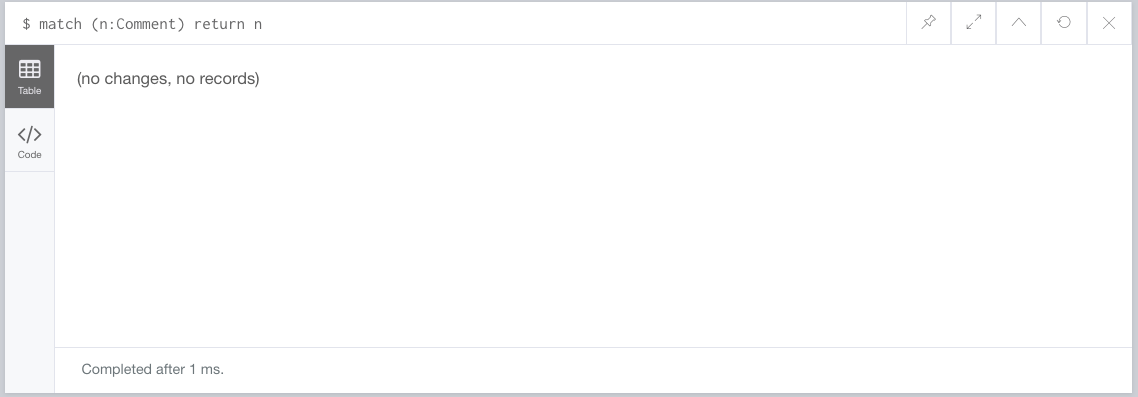 |
| :---: |
| __No Comments up my Sleeve__ |

In [44]:
def test_create_comment():
    # John Adams was from Boston. We would think that the Sox and Pedroia are awesome, if he were not dead.
    c = fg.create_comment("ja1", "Awesome", team_id="BOS", player_id="pedrodu01")
    print(c)

In [45]:
test_create_comment()

(_21788:Comment {comment: 'Awesome', comment_id: '5b82d01b-79fa-4cd3-af8d-89ab74306924'})


- Use the explore to see if it is there.

| ![image.png](image1.png) |
| :---: |
| __Comment Created__ |

In [46]:
def test_get_comment():
    cid = "5b82d01b-79fa-4cd3-af8d-89ab74306924"
    print("Getting comment with ID = ", cid)

    c = fg.get_comment(cid)

    if c is not None:
        print("The type I got is ...", type(c))
        print("And the data is = ", json.dumps(c, indent=2))
    else:
        print("I got nothing?")
    
    print("\nOh, wait. [That was a UUID. Mine will be different.")
    print("I can go into the browser exploring the graph and copy a UUID.")
    g = fg.get_comment("5b82d01b-79fa-4cd3-af8d-89ab74306924")
    print("Type is = ", type(g))
    print("And what I got is = ", g)
    print("The data is = ", json.dumps(g, indent=2))
    print("And just the comment attribute is ...", g['comment_id'])

In [47]:
test_get_comment()

Getting comment with ID =  5b82d01b-79fa-4cd3-af8d-89ab74306924
The type I got is ... <class 'py2neo.data.Node'>
And the data is =  {
  "comment_id": "5b82d01b-79fa-4cd3-af8d-89ab74306924",
  "comment": "Awesome"
}

Oh, wait. [That was a UUID. Mine will be different.
I can go into the browser exploring the graph and copy a UUID.
Type is =  <class 'py2neo.data.Node'>
And what I got is =  (_21788:Comment {comment: 'Awesome', comment_id: '5b82d01b-79fa-4cd3-af8d-89ab74306924'})
The data is =  {
  "comment_id": "5b82d01b-79fa-4cd3-af8d-89ab74306924",
  "comment": "Awesome"
}
And just the comment attribute is ... 5b82d01b-79fa-4cd3-af8d-89ab74306924


- Sub comments

In [48]:
def test_create_sub_comment():
    c = fg.create_sub_comment("wxq", origin_comment_id="5b82d01b-79fa-4cd3-af8d-89ab74306924", comment="Awesome+1")
    print(json.dumps(c, indent=2))

In [49]:
test_create_sub_comment()

{
  "origin_comment_id": "5b82d01b-79fa-4cd3-af8d-89ab74306924",
  "comment": "Awesome+1"
}


In [50]:
def test_get_sub_comments():

    # Let's run Prof. Ferguson's test code.
    cid = "5b82d01b-79fa-4cd3-af8d-89ab74306924"
    print("I learned my lesson from getting comments and manually got a UUID.")
    print("Get sub-comments for comment_id = ", cid)
    g = fg.get_sub_comments(comment_id=cid)
    print("The type I got is ...", type(g))
    print("And the data is = ", g.data())

    print("\n\nThat was kind of icky. Let's run the query again.")
    g = fg.get_sub_comments(comment_id=cid)
    print("Iterators rock!")
    for n in g:
        print("Original comment = ", dict(n['sc']))
        print("Response comment = ", dict(n['c']))

    print("How did that maniac produce that data? That would be a good homework question.")

In [51]:
test_get_sub_comments()

I learned my lesson from getting comments and manually got a UUID.
Get sub-comments for comment_id =  5b82d01b-79fa-4cd3-af8d-89ab74306924
The type I got is ... <class 'py2neo.database.Cursor'>
And the data is =  [{'sc': (_21788:Comment {comment: 'Awesome', comment_id: '5b82d01b-79fa-4cd3-af8d-89ab74306924'}), 'r': (_21790)-[:RESPONSE_OF {}]->(_21788), 'c': (_21790:Response {comment: 'Awesome+1', origin_comment_id: '5b82d01b-79fa-4cd3-af8d-89ab74306924'})}]


That was kind of icky. Let's run the query again.
Iterators rock!
Original comment =  {'comment_id': '5b82d01b-79fa-4cd3-af8d-89ab74306924', 'comment': 'Awesome'}
Response comment =  {'comment': 'Awesome+1', 'origin_comment_id': '5b82d01b-79fa-4cd3-af8d-89ab74306924'}
How did that maniac produce that data? That would be a good homework question.


- Player comments

In [52]:
def test_get_player_comments():

    # Get comments on a player by player_id.
    g = fg.get_player_comments("pedrodu01")

    # I ran a query, and did not use NodeMatcher or RelationshipMatcher. This gives me a cursor.
    print("get_player_comments returned type: ", type(g))
    print("By definition, your can iterate on cursors.")
    recs = []
    for n in g:
        # Since I ran a query that returns ATTRIBUTES of the nodes and relationships that match the
        # cursor, and not the nodes and relationships, the return is a record.
        print("Type of n is ", type(n))
        print("JSON for n is \n", json.dumps(n, indent=2))

        # I will put at the end of a list of records.
        recs.append(n)

    # Pandas likes records, dicts, etc. Let's load a data frame and display it.
    pd.set_option('display.width', 100)
    df = pd.DataFrame.from_records(recs, columns=['UNI', 'last_name', 'first_name', 'comment_id', 'comment', \
                                                      'player_id', 'player_last_name', 'player_first_name'])
    print("\nLoaded into a DataFrame = \n", df)

    # Try getting the
    print("\n After iteration, the data under cursor is = ", g.data())
    print("Where of where has my data gone? Oh, wait. I iterated through the cursor.")
    print("Run the query again.")
    g = fg.get_player_comments("pedrodu01")
    print("Show the data.")
    print(json.dumps(g.data(), indent=2))
    print("Now I can load into a DataFrame.")
    df = pd.DataFrame.from_dict(g.data())
    print("\nLoaded into a DataFrame = \n", df)

    print("AAARGH. I ran through the cursor again. Once more, with feelings.")
    g = fg.get_player_comments("pedrodu01")
    df = pd.DataFrame.from_dict(g.data())
    print("\nLoaded into a DataFrame = \n", df)


In [53]:
test_get_player_comments()

get_player_comments returned type:  <class 'py2neo.database.Cursor'>
By definition, your can iterate on cursors.
Type of n is  <class 'py2neo.data.Record'>
JSON for n is 
 [
  "ja1",
  "Adams",
  "John",
  "5b82d01b-79fa-4cd3-af8d-89ab74306924",
  "Awesome",
  "pedrodu01",
  "Pedroia",
  "Dustin"
]

Loaded into a DataFrame = 
    UNI last_name first_name                            comment_id  comment  player_id  \
0  ja1     Adams       John  5b82d01b-79fa-4cd3-af8d-89ab74306924  Awesome  pedrodu01   

  player_last_name player_first_name  
0          Pedroia            Dustin  

 After iteration, the data under cursor is =  []
Where of where has my data gone? Oh, wait. I iterated through the cursor.
Run the query again.
Show the data.
[
  {
    "fan.uni": "ja1",
    "fan.last_name": "Adams",
    "fan.first_name": "John",
    "comment.comment_id": "5b82d01b-79fa-4cd3-af8d-89ab74306924",
    "comment.comment": "Awesome",
    "player.player_id": "pedrodu01",
    "player.last_name": "Pedr

In [54]:
# Make another comment from another person.
fg.create_comment("gw1", "Totally", "BOS", "pedrodu01")

(_17545:Comment {comment: 'Totally', comment_id: '90130b0f-5f07-463c-9dcc-f930a9227520'})

- The graph now looks like ...


| ![image.png](image2.png) |
| :---: |
| __Created__ |

In [55]:
c = test_get_player_comments()
c

get_player_comments returned type:  <class 'py2neo.database.Cursor'>
By definition, your can iterate on cursors.
Type of n is  <class 'py2neo.data.Record'>
JSON for n is 
 [
  "gw1",
  "Washing",
  "George",
  "90130b0f-5f07-463c-9dcc-f930a9227520",
  "Totally",
  "pedrodu01",
  "Pedroia",
  "Dustin"
]
Type of n is  <class 'py2neo.data.Record'>
JSON for n is 
 [
  "ja1",
  "Adams",
  "John",
  "90130b0f-5f07-463c-9dcc-f930a9227520",
  "Totally",
  "pedrodu01",
  "Pedroia",
  "Dustin"
]
Type of n is  <class 'py2neo.data.Record'>
JSON for n is 
 [
  "gw1",
  "Washing",
  "George",
  "5b82d01b-79fa-4cd3-af8d-89ab74306924",
  "Awesome",
  "pedrodu01",
  "Pedroia",
  "Dustin"
]
Type of n is  <class 'py2neo.data.Record'>
JSON for n is 
 [
  "ja1",
  "Adams",
  "John",
  "5b82d01b-79fa-4cd3-af8d-89ab74306924",
  "Awesome",
  "pedrodu01",
  "Pedroia",
  "Dustin"
]

Loaded into a DataFrame = 
    UNI last_name first_name                            comment_id  comment  player_id  \
0  gw1   Wash

- Team comments

In [56]:
# My base function simple returns a RelationshipMatch
c = fg.get_team_comments('BOS')
print(c, "\n\n")

# This is kind of kooky. So, we need to unwind it.
# Let's see the whole structure. Start be seeing what is in the result set,
for r in c:
    print(r)

print("\n\nOK. A bunch of relationships")



<Record t=(_18727:Team {team_id: 'BOS', team_name: 'Boston Red Sox'}) r=(_17545)-[:COMMENT_ON {}]->(_18727) c=(_17545:Comment {comment: 'Totally', comment_id: '90130b0f-5f07-463c-9dcc-f930a9227520'})>
<Record t=(_18727:Team {team_id: 'BOS', team_name: 'Boston Red Sox'}) r=(_21788)-[:COMMENT_ON {}]->(_18727) c=(_21788:Comment {comment: 'Awesome', comment_id: '5b82d01b-79fa-4cd3-af8d-89ab74306924'})>


OK. A bunch of relationships


In [57]:
def test_get_team_comments():
    g = fg.get_team_comments("BOS")

    # What did I get?
    print("Result = ", g)
    print("Result type = ", type(g))

    print("\nSince I read the manual and know how to probe API results, I realize I can iterate.")
    for n in g:
        print("\n\tGot something of type = ", type(n))
        print("\tThe properties of the thing I got are = ", json.dumps(n, indent=2))

In [58]:
test_get_team_comments()

Result =  <py2neo.database.Cursor object at 0x11a53c208>
Result type =  <class 'py2neo.database.Cursor'>

Since I read the manual and know how to probe API results, I realize I can iterate.

	Got something of type =  <class 'py2neo.data.Record'>
	The properties of the thing I got are =  [
  {
    "team_name": "Boston Red Sox",
    "team_id": "BOS"
  },
  {},
  {
    "comment_id": "90130b0f-5f07-463c-9dcc-f930a9227520",
    "comment": "Totally"
  }
]

	Got something of type =  <class 'py2neo.data.Record'>
	The properties of the thing I got are =  [
  {
    "team_name": "Boston Red Sox",
    "team_id": "BOS"
  },
  {},
  {
    "comment_id": "5b82d01b-79fa-4cd3-af8d-89ab74306924",
    "comment": "Awesome"
  }
]


- Get Player by Team

In [59]:
def test_get_players_by_team():
    g = fg.get_players_by_team("BOS", 2016)
    r = pd.DataFrame(g.data())
    return (r)

In [60]:
test_get_players_by_team()

,a.games,a.year,p.first_name,p.last_name,p.player_id,t.team_id,t.team_name
0,33,2016,Brad,Ziegler,zieglbr01,BOS,Boston Red Sox
1,76,2016,Chris,Young,youngch04,BOS,Boston Red Sox
2,25,2016,Steven,Wright,wrighst01,BOS,Boston Red Sox
3,57,2016,Christian,Vazquez,vazquch01,BOS,Boston Red Sox
4,50,2016,Koji,Uehara,ueharko01,BOS,Boston Red Sox
5,53,2016,Junichi,Tazawa,tazawju01,BOS,Boston Red Sox
6,19,2016,Blake,Swihart,swihabl01,BOS,Boston Red Sox
7,3,2016,Carson,Smith,smithca02,BOS,Boston Red Sox
8,145,2016,Travis,Shaw,shawtr01,BOS,Boston Red Sox
9,7,2016,Robby,Scott,scottro02,BOS,Boston Red Sox


## Redis $-$ HW4 Part 2

### Concept

- One of the most common uses of Redis is as a web response or API cache.

| 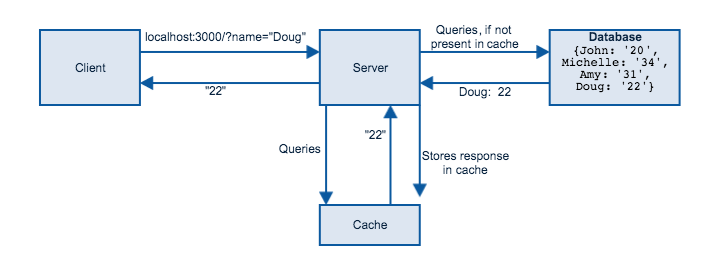 |
| :---: |
| SQL Result Cache |

|  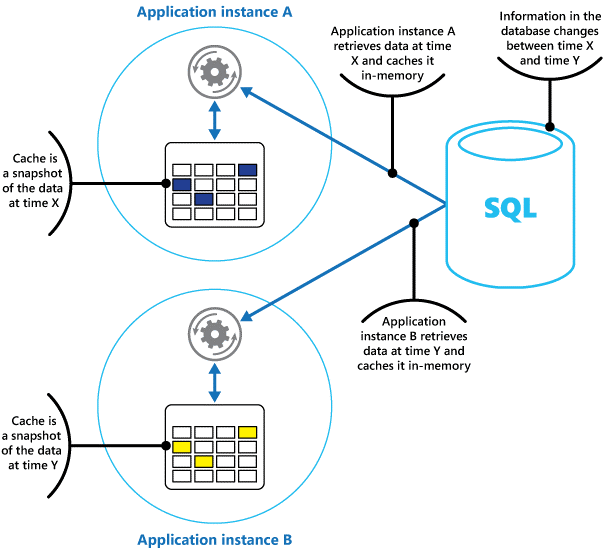|
| :---: |
| DB Cache in Web Application Flow |

- HW4 will use Redis to implement a simple result cache in front of $retrieve\_by\_template().$

### Starting Code

In [42]:
import redis
from operator import itemgetter
import json

"""
Connect to local Redis server. StrictRedis complies more closely with standard than
simple Redis client in this package. decode_responses specifies whether or not to convert
bytes to UTF8 character string or treat as raw bytes, e.g. an image, audio stream, etc.
"""
r = redis.StrictRedis(
    host='localhost',
    port=6379,
    charset="utf-8", decode_responses=True)


def add_to_cache(key, value):
    """

    :param key: A valid Redis key string.
    :param value: A Python dictionary to add to cache.
    :return: None
    """
    k = key
    #ut.debug_message("Adding key = ", k)
    #ut.debug_message("Adding data", value)
    r.set(k, value)


def get_from_cache(key):
    """

    :param key: A valid Redis key.
    :return: The "map object" associated with the key.
    """
    result = r.get(key)
    return result

def get_keys():
    result = r.keys()
    return result

def save_dict(k, d):
    result = r.hmset(k, d)
    return result

def get_dict(k):
    result = r.hgetall(k)
    return result


- Tests

In [38]:
get_keys()

['bob',
 '{"table": "People", "template": {"nameLast": "Williams", "birthcity": "San Diego"}, "fields": " * ", "limit": null, "offset": null, "orderBy": null}',
 '2cool']

In [23]:
d = {"playerID": "cool", "title": "Imaginary"}

In [24]:
save_dict("2cool", d)

True

In [25]:
r = get_dict("2cool")
print(r)

{'playerID': 'cool', 'title': 'Imaginary'}


In [63]:
result = [{"id": 10, "uni": "dff9"}, {"iq": "202", "uni": "foo"}]

In [66]:
s = json.dumps(result)
s

'[{"id": 10, "uni": "dff9"}, {"iq": "202", "uni": "foo"}]'

In [71]:
add_to_cache("bob", s)

In [73]:
rr = get_from_cache('bob')
rr

'[{"id": 10, "uni": "dff9"}, {"iq": "202", "uni": "foo"}]'

In [75]:
real_r = json.loads(rr)
real_r

[{'id': 10, 'uni': 'dff9'}, {'iq': '202', 'uni': 'foo'}]

### Homework



- HW4 will add checking the Redis cache to a simple, standalone $retrieve\_by\_template()$ function.
    1. Write a function $add\_to\_cache()$ that adds a retrieve result to the cache.
    2. Write a function $retrieve\_from\_cache()$ that checks the cache and returns the value if present.
    3. Modify $retrieve\_by\_template()$ to use the cache.
        1. Check and return if cached.
        2. Call DB and add to cache if not cached.
        

### Some Helper Code


- Some helper code

In [26]:
import pymysql.cursors
import json
import copy


db_schema = None                                # Schema containing accessed data
cnx = None                                      # DB connection to use for accessing the data.
key_delimiter = '_'                             # This should probably be a config option.


default_db_params = {
    "dbhost": "localhost",                    # Changeable defaults in constructor
    "port": 3306,
    "dbname": "lahman2017",
    "dbuser": "dbuser",
    "dbpw": "dbuserdbuser",
    "cursorClass": pymysql.cursors.DictCursor,        # Default setting for DB connections
    "charset":  'utf8mb4'                             # Do not change
}

def get_new_connection(params=default_db_params):
    cnx = pymysql.connect(
        host=params["dbhost"],
        port=params["port"],
        user=params["dbuser"],
        password=params["dbpw"],
        db=params["dbname"],
        charset=params["charset"],
        cursorclass=params["cursorClass"])
    return cnx

def set_config():
    """
    Creates the DB connection and sets the global variables.

    :param cfg: Application configuration data.
    :return: None
    """
    global db_schema
    global cnx

    db_params = {
        "dbhost": "localhost",
        "port": 3306,
        "dbname": "lahman2017",
        "dbuser": "dbuser",
        "dbpw": "dbuserdbuser",
        "cursorClass": pymysql.cursors.DictCursor,
        "charset": 'utf8mb4'
    }

    db_schema = "lahman2017"

    cnx = get_new_connection(db_params)


# Given one of our magic templates, forms a WHERE clause.
# { a: b, c: d } --> WHERE a=b and c=d. Currently treats everything as a string.
# We can fix this by using PyMySQL connector query templates.
def templateToWhereClause(t):
    s = ""
    for k,v in t.items():
        if s != "":
            s += " AND "
        s += k + "='" + v + "'"

    if s != "":
        s = "WHERE " + s;

    return s

In [27]:
def check_query_cache(resource, template, fields):
    
    key = compute_key(resource, template, fields)
    result = get_from_cache(key)
    if result is not None and len(result) > 0:
        result = json.loads(result)
        
    return result

def  add_to_query_cache(resource, template, fields, q_result):
    
    key = compute_key(resource, template, fields)
    result = add_to_cache(key, json.dumps(q_result))
    return result

In [28]:
def run_q(cnx, q, args, fetch=False, commit=True):
    """
    :param cnx: The database connection to use.
    :param q: The query string to run.
    :param args: Parameters to insert into query template if q is a template.
    :param fetch: True if this query produces a result and the function should perform and return fetchall()
    :return:
    """
    #debug_message("run_q: q = " + q)
    #ut.debug_message("Q = " + q)
    #ut.debug_message("Args = ", args)

    result = None

    try:
        cursor = cnx.cursor()
        result = cursor.execute(q, args)
        if fetch:
            result = cursor.fetchall()
        if commit:
            cnx.commit()
    except pymysql_exceptions as original_e:
        #print("dffutils.run_q got exception = ", original_e)
        raise(original_e)

    return result

In [33]:
cnx = get_new_connection()
def retrieve_by_template(table, t, fields=None, limit=None, offset=None, orderBy=None, use_cache=False):

    if use_cache:
        result = check_cache(table, t, fields, limit, offset, orderBy)
        print("\nCheck cache returned", result, "\n")
        if result is not None and len(result) > 0:
            print("CACHE HIT")
            return result
        else:
            print("CACHE MISS")
            
    original_fields = fields

            
    if t is not None:
        w = templateToWhereClause(t)
    else:
        w = ""

    if orderBy is not None:
        o = "order by " + ",".join(orderBy['fields']) + " " + orderBy['direction'] + " "
    else:
        o = ""

    if limit is not None:
        w += " LIMIT " + str(limit)
    if offset is not None:
        w += " OFFSET " + str(offset)

    if fields is None:
        fields = " * "
    else:
        fields = " " + ",".join(fields) + " "

    cursor=cnx.cursor()
    q = "SELECT " + fields + " FROM " + table + " " + w + ";"

    r = run_q(cnx, q, None, fetch=True, commit=True)
    
    if use_cache and r is not None and len(r) > 0:
        save_to_cache(table, t, original_fields, limit, offset, orderBy, r)

    return r

In [34]:
def compute_key(resource, template, fields):
    t = None
    f = None

    if template is not None:
        t = template.items()
        t = tuple(t)
        sorted(t, key=itemgetter(1))
        ts = [str(e[0]) + "=" + str(e[1]) for e in t]
        t = ",".join(ts)

    if fields is not None:
        f = sorted(fields)
        f = "f = " + (",".join(f))

    if f is not None or t is not None:
        result = resource + ":"
    else:
        result = resource

    if t is not None:
        result += t

    if f is not None and t is not None:
        result += "," + f
    elif f is not None and t is None:
        result += f

    return result

def check_cache(table, tmp, fields, limit, offset, orderBy):
    
    cache_tmp = copy.copy(tmp)
    if limit:
        cache_tmp['limit'] = limit
    if offset:
        cache_tmp['offset'] = offset
    if orderBy:
        cache_tmp['orderBy'] = orderBy
        
    result = check_query_cache(table, cache_tmp, fields)
    return result
        
    cache_k = compute_cache_key(table, tmp, fields, limit, offset, orderBy)
    print("Key = ", cache_k)
    print("Type of key is", type(cache_k))
    res = get_from_cache(cache_k)
    print("res = ", res)
    return res

def save_to_cache(table, tmp, fields, limit, offset, orderBy, q_result):
    cache_tmp = copy.copy(tmp)
    if limit:
        cache_tmp['limit'] = limit
    if offset:
        cache_tmp['offset'] = offset
    if orderBy:
        cache_tmp['orderBy'] = orderBy
        
    result = add_to_query_cache(table, cache_tmp, fields, q_result)
    return result

#### Some Test Code

- Switching to my super secret implementation.

In [35]:
tmp = {"nameLast": "Williams", "birthcity": "San Diego"}
r3 = retrieve_by_template("People", tmp)
r3

[{'playerID': 'willite01',
  'birthYear': 1918,
  'birthMonth': 8,
  'birthDay': 30,
  'birthCountry': 'USA',
  'birthState': 'CA',
  'birthCity': 'San Diego',
  'deathYear': 2002,
  'deathMonth': 7,
  'deathDay': 5,
  'deathCountry': 'USA',
  'deathState': 'FL',
  'deathCity': 'Inverness',
  'nameFirst': 'Ted',
  'nameLast': 'Williams',
  'nameGiven': 'Theodore Samuel',
  'weight': '205',
  'height': '75',
  'bats': 'L',
  'throws': 'R',
  'debut': '1939-04-20',
  'finalGame': '1960-09-28',
  'retroID': 'willt103',
  'bbrefID': 'willite01',
  'DOD': datetime.date(2002, 7, 5),
  'DOB': datetime.date(1918, 8, 30)},
 {'playerID': 'willitr01',
  'birthYear': 1992,
  'birthMonth': 4,
  'birthDay': 25,
  'birthCountry': 'USA',
  'birthState': 'CA',
  'birthCity': 'San Diego',
  'deathYear': None,
  'deathMonth': None,
  'deathDay': None,
  'deathCountry': '',
  'deathState': '',
  'deathCity': '',
  'nameFirst': 'Trevor',
  'nameLast': 'Williams',
  'nameGiven': 'Trevor Anthony',
  'weight'

In [43]:
tmp = { "nameLast": "Williams", "birthState": "CA"}
fields = ["playerID", "nameLast", "nameFirst", "throws"]
resource = "People"

result = retrieve_by_template(resource, tmp, fields, use_cache=True)
result


Check cache returned None 

CACHE MISS


[{'playerID': 'willibe01',
  'nameLast': 'Williams',
  'nameFirst': 'Bernie',
  'throws': 'R'},
 {'playerID': 'willido02',
  'nameLast': 'Williams',
  'nameFirst': 'Don',
  'throws': 'R'},
 {'playerID': 'williji03',
  'nameLast': 'Williams',
  'nameFirst': 'Jimy',
  'throws': 'R'},
 {'playerID': 'willike02',
  'nameLast': 'Williams',
  'nameFirst': 'Ken',
  'throws': 'R'},
 {'playerID': 'willima04',
  'nameLast': 'Williams',
  'nameFirst': 'Matt',
  'throws': 'R'},
 {'playerID': 'willimi02',
  'nameLast': 'Williams',
  'nameFirst': 'Mitch',
  'throws': 'L'},
 {'playerID': 'williri02',
  'nameLast': 'Williams',
  'nameFirst': 'Rinaldo',
  'throws': 'R'},
 {'playerID': 'williri03',
  'nameLast': 'Williams',
  'nameFirst': 'Rick',
  'throws': 'R'},
 {'playerID': 'willish01',
  'nameLast': 'Williams',
  'nameFirst': 'Shad',
  'throws': 'R'},
 {'playerID': 'willite01',
  'nameLast': 'Williams',
  'nameFirst': 'Ted',
  'throws': 'R'},
 {'playerID': 'willitr01',
  'nameLast': 'Williams',
  'n

In [45]:
result = retrieve_by_template(resource, tmp, fields, use_cache=True)


Check cache returned [{'playerID': 'willibe01', 'nameLast': 'Williams', 'nameFirst': 'Bernie', 'throws': 'R'}, {'playerID': 'willido02', 'nameLast': 'Williams', 'nameFirst': 'Don', 'throws': 'R'}, {'playerID': 'williji03', 'nameLast': 'Williams', 'nameFirst': 'Jimy', 'throws': 'R'}, {'playerID': 'willike02', 'nameLast': 'Williams', 'nameFirst': 'Ken', 'throws': 'R'}, {'playerID': 'willima04', 'nameLast': 'Williams', 'nameFirst': 'Matt', 'throws': 'R'}, {'playerID': 'willimi02', 'nameLast': 'Williams', 'nameFirst': 'Mitch', 'throws': 'L'}, {'playerID': 'williri02', 'nameLast': 'Williams', 'nameFirst': 'Rinaldo', 'throws': 'R'}, {'playerID': 'williri03', 'nameLast': 'Williams', 'nameFirst': 'Rick', 'throws': 'R'}, {'playerID': 'willish01', 'nameLast': 'Williams', 'nameFirst': 'Shad', 'throws': 'R'}, {'playerID': 'willite01', 'nameLast': 'Williams', 'nameFirst': 'Ted', 'throws': 'R'}, {'playerID': 'willitr01', 'nameLast': 'Williams', 'nameFirst': 'Trevor', 'throws': 'R'}] 

CACHE HIT


## DynamoDB Code

### DynamoDB Python API

#### Functions

|                 |                     |
|----------------------------------|----------------------------------|
| batch_get_item()                 | get_waiter()                     |
| batch_write_item()               | list_backups()                   |
| can_paginate()                   | list_global_tables()             |
| create_backup()                  | list_tables()                    |
| create_global_table()            | list_tags_of_resource()          |
| create_table()                   | put_item()                       |
| delete_backup()                  | query()                          |
| delete_item()                    | restore_table_from_backup()      |
| delete_table()                   | restore_table_to_point_in_time() |
| describe_backup()                | scan()                           |
| describe_continuous_backups()    | tag_resource()                   |
| describe_endpoints()             | untag_resource()                 |
| describe_global_table()          | update_continuous_backups()      |
| describe_global_table_settings() | update_global_table()            |
| describe_limits()                | update_global_table_settings()   |
| describe_table()                 | update_item()                    |
| describe_time_to_live()          | update_table()                   |
| generate_presigned_url()         | update_time_to_live()            |
| get_item()                       |   get_paginator()                |
| | [DynamoDB Python API](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/dynamodb.html) |

- Lot's of obvious operations for reading, writing, getting metadata, etc.


- Unlike a DB, you must use pagination. There are no cursors or fetchall().


- No functions like JOIN. 


- The primary functions are:
    - ```get_item(), delete_item()``` and ```put_item(),``` which are link select, delete and insert using a primary key for an RDB.
    - ```scan(),``` which is like a ```select ... where ... ``` but using a different format for project and select clauses.
    - There is also support for batch operations, because the primary focus is web scale performance.

### Examples

#### Overview

- I downloaded and am using the "local" DynamoDB for these tests. See https://docs.aws.amazon.com/amazondynamodb/latest/developerguide/DynamoDBLocal.html.


- I used the AWS Command Line (CLI) to create the local tables.

```
aws dynamodb create-table --table-name
CustomerProfileTypes --attribute-definitions AttributeName=profile_label,AttributeType=S
--key-schema AttributeName=profile_label,KeyType=HASH
--provisioned-throughput ReadCapacityUnits=5,WriteCapacityUnits=5 --endpoint-url http://localhost:8000
```

- The tests below actually use a cloud DynamoDB

#### Setup the Client

In [ ]:
import boto3

client = boto3.client('dynamodb')
from boto3.dynamodb.conditions import Key, Attr

# There is some weird stuff in DynamoDB JSON responses. These utils work better.
from dynamodb_json import json_util as jsond

#dynamodb = boto3.resource('dynamodb'), endpoint_url='http://localhost:8000')

dynamodb = boto3.resource('dynamodb')

#### Get and Item from a Table

In [10]:
def do_a_get(table_name, key):
    table = dynamodb.Table(table_name)

    response = table.get_item(
        Key=key
    )

    print("GetItem succeeded:")
    return response
    #print(json.dumps(response, indent=4))

In [13]:
response = do_a_get('orders', key = {
        "order_number" : "O123"
    })
print(json.dumps(response, indent=4, default=str))

GetItem succeeded:
{
    "Item": {
        "orderDate": "2003-01-06",
        "orderdetails": [
            {
                "quantityOrdered": "49",
                "productCode": "S24_3969",
                "orderLineNumber": "1",
                "priceEach": "35.29"
            },
            {
                "quantityOrdered": "50",
                "productCode": "S18_2248",
                "orderLineNumber": "2",
                "priceEach": "55.09"
            },
            {
                "quantityOrdered": "30",
                "productCode": "S18_1749",
                "orderLineNumber": "3",
                "priceEach": "136.00"
            },
            {
                "quantityOrdered": "22",
                "productCode": "S18_4409",
                "orderLineNumber": "4",
                "priceEach": "75.46"
            }
        ],
        "status": "Shipped",
        "comments": null,
        "requiredDate": "2003-01-13",
        "order_number": "O123",
        

#### Get Table Metadata

In [14]:
def describe_table(table_name):
    result = client.describe_table(TableName='CustomerProfileTypes')
    print(jsond.dumps(result, indent=3))

In [15]:
describe_table('CustomerProfileTypes')

{
   "Table": {
      "M": {
         "AttributeDefinitions": {
            "L": [
               {
                  "M": {
                     "AttributeName": {
                        "S": "profile_label"
                     },
                     "AttributeType": {
                        "S": "S"
                     }
                  }
               }
            ]
         },
         "TableName": {
            "S": "CustomerProfileTypes"
         },
         "KeySchema": {
            "L": [
               {
                  "M": {
                     "AttributeName": {
                        "S": "profile_label"
                     },
                     "KeyType": {
                        "S": "HASH"
                     }
                  }
               }
            ]
         },
         "TableStatus": {
            "S": "ACTIVE"
         },
         "CreationDateTime": {
            "S": "2018-10-11T09:39:31.455000"
         },
         "ProvisionedThrough

#### Put an Item

In [17]:
def do_a_put(table_name, item):
    table = dynamodb.Table(table_name)
    response = table.put_item(
        Item=item
    )
    return response

In [18]:
o_all_1 = {
            "order_number": "O124",
            "orderDate": "2003-01-31",
            "requiredDate": "2003-04-13",
            "shippedDate": "2003-04-10",
            "status": "Shipped",
            "comments": None,
            "customerNumber": 101, 
    "orderdetails":
        [
        {
            "productCode": "S24_3969",
            "quantityOrdered": 49,
            "priceEach": "35.29",
            "orderLineNumber": 2
        },
        {
            "productCode": "S12_1001",
            "quantityOrdered": 100,
            "priceEach": "35.29",
            "orderLineNumber": 11
        }
        ]
}

result = do_a_put('orders',
            o_all_1)
print(json.dumps(result, indent=4))

{
    "ResponseMetadata": {
        "RequestId": "BON3JD85II8GCDUFI5SPOJP9KNVV4KQNSO5AEMVJF66Q9ASUAAJG",
        "HTTPStatusCode": 200,
        "HTTPHeaders": {
            "server": "Server",
            "date": "Thu, 18 Apr 2019 17:08:46 GMT",
            "content-type": "application/x-amz-json-1.0",
            "content-length": "2",
            "connection": "keep-alive",
            "x-amzn-requestid": "BON3JD85II8GCDUFI5SPOJP9KNVV4KQNSO5AEMVJF66Q9ASUAAJG",
            "x-amz-crc32": "2745614147"
        },
        "RetryAttempts": 0
    }
}


#### Scan a Table

In [22]:
def do_a_scan(table_name, filterexpression):
    table = dynamodb.Table(table_name)

    if filterexpression is not None:
        response = table.scan(
            filterexpression
        )
    else:
        response = table.scan(
        )

    print("Scan succeeded")
    #print(json.dumps(response, indent=4))
    return response

In [23]:
response = do_a_scan('orders', filterexpression=None)
print("Scan = ", json.dumps(response, indent=2, default=str))

Scan succeeded
Scan =  {
  "Items": [
    {
      "orderDate": "2003-01-31",
      "orderdetails": [
        {
          "quantityOrdered": "49",
          "productCode": "S24_3969",
          "orderLineNumber": "2",
          "priceEach": "35.29"
        },
        {
          "quantityOrdered": "100",
          "productCode": "S12_1001",
          "orderLineNumber": "11",
          "priceEach": "35.29"
        }
      ],
      "status": "Shipped",
      "comments": null,
      "requiredDate": "2003-04-13",
      "order_number": "O124",
      "customerNumber": "101",
      "shippedDate": "2003-04-10"
    },
    {
      "orderDate": "2003-01-06",
      "orderdetails": [
        {
          "quantityOrdered": "49",
          "productCode": "S24_3969",
          "orderLineNumber": "1",
          "priceEach": "35.29"
        },
        {
          "quantityOrdered": "50",
          "productCode": "S18_2248",
          "orderLineNumber": "2",
          "priceEach": "55.09"
        },
     

In [25]:
FilterExpression = Attr('customerNumber').eq(363)
response = do_a_scan('orders', FilterExpression)
print("Scan = ", json.dumps(response, indent=2, default=str))

Scan succeeded
Scan =  {
  "Items": [
    {
      "orderDate": "2003-01-31",
      "orderdetails": [
        {
          "quantityOrdered": "49",
          "productCode": "S24_3969",
          "orderLineNumber": "2",
          "priceEach": "35.29"
        },
        {
          "quantityOrdered": "100",
          "productCode": "S12_1001",
          "orderLineNumber": "11",
          "priceEach": "35.29"
        }
      ],
      "status": "Shipped",
      "comments": null,
      "requiredDate": "2003-04-13",
      "order_number": "O124",
      "customerNumber": "101",
      "shippedDate": "2003-04-10"
    },
    {
      "orderDate": "2003-01-06",
      "orderdetails": [
        {
          "quantityOrdered": "49",
          "productCode": "S24_3969",
          "orderLineNumber": "1",
          "priceEach": "35.29"
        },
        {
          "quantityOrdered": "50",
          "productCode": "S18_2248",
          "orderLineNumber": "2",
          "priceEach": "55.09"
        },
     